In [28]:
from __future__ import print_function
%load_ext autoreload
%autoreload 2
import os
if not os.path.exists('plots/'):
    os.mkdir('plots')

from six.moves import cPickle
from collections import defaultdict, OrderedDict

import numpy as np
import tf_keras.backend as K

import kde
import simplebinmi
import matrixRenyi
import utils


DO_SAVE        = True    # Whether to save plots or just show them
DO_LOWER       = False   # Whether to compute lower bounds also
DO_BINNED      = True     # Whether to compute MI estimates based on binning
DO_MATRIX_BASED = True

# Max number of epoch for which to compute mutual information measure
MAX_EPOCHS = 501
COLORBAR_MAX_EPOCHS = 501

# Directories from which to load saved layer activity
ARCH = '512-256-128-64-32-16-10-10'
# ARCH = '10-10-10-10'

# DIR_TEMPLATE = '%%s_%s'%ARCH
DIR_TEMPLATE = '%%s_%s'%ARCH
# Functions to return upper and lower bounds on entropy of layer activity
# refer demo.py for more details
noise_variance = 0.1             # Added Gaussian noise variance
Klayer_activity = K.placeholder(ndim=2)  # Keras placeholder 
entropy_func_upper = K.function([Klayer_activity,], [kde.entropy_estimator_kl(Klayer_activity, noise_variance),])
entropy_func_lower = K.function([Klayer_activity,], [kde.entropy_estimator_bd(Klayer_activity, noise_variance),])


# nats to bits conversion factor
nats2bits = 1.0/np.log(2) 

# Save indexes of tests data for each of the output classes
bin_size = 0.2
trn, tst = utils.get_mnist(training_percent=100)

saved_labelixs = {}
full = utils.construct_full_dataset(trn, tst)

FULL_MI = False
if FULL_MI:
    labelprobs = np.mean(full.Y, axis=0)
    for i in range(10):
        saved_labelixs[i] = full.y == i
else:
    for i in range(10):
        saved_labelixs[i] = tst.y == i
labelprobs = np.mean(tst.Y, axis=0)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
PLOT_LAYERS    = None     # Which layers to plot.  If None, all saved layers are plotted 

# Data structure used to store results
measures = OrderedDict()
measures['tanh'] = {}

Compute MI measures
-----

In [30]:
for activation in measures.keys():
    cur_dir = 'rawdata/' + DIR_TEMPLATE % activation
    if not os.path.exists(cur_dir):
        # print("Directory %s not found" % cur_dir)
        continue
    # Load files saved during each epoch, and compute MI measures of the activity in that epoch
    # print('*** Doing %s ***' % cur_dir)
    for epochfile in sorted(os.listdir(cur_dir)):
        if not epochfile.startswith('epoch'):
            continue
        fname = cur_dir + "/" + epochfile
        with open(fname, 'rb') as f:
            d = cPickle.load(f)
        epoch = d['epoch']
        if epoch in measures[activation]: # Skip this epoch if its already been processed
            continue                      # this is a trick to allow us to rerun this cell multiple times)
            
        if epoch > MAX_EPOCHS:
            continue

        print("Doing", fname)
        num_layers = len(d['data']['activity_tst'])

        if PLOT_LAYERS is None:
            PLOT_LAYERS = []
            for lndx in range(num_layers):
                # if d['data']['activity_tst'][lndx].shape[1] < 200 and lndx != num_layers - 1:
                PLOT_LAYERS.append(lndx)
       
        cepochdata = defaultdict(list)

        for lndx in range(num_layers):
                
            # only use the test data
            activity = d['data']['activity_tst'][lndx][60000:]
            # use the full dataset
            # activity = d['data']['activity_tst'][lndx]
            
            if lndx == num_layers-1:    
                activity = activity * 2   # The range of the last layer is [0,1]
            # Compute marginal entropies
            h_upper = entropy_func_upper([activity,])[0]
            if DO_LOWER:
                h_lower = entropy_func_lower([activity,])[0]
                
            # Layer activity given input. This is simply the entropy of the Gaussian noise
            hM_given_X = kde.kde_condentropy(activity, noise_variance)
            
            # Compute conditional entropies of layer activity given output
            hM_given_Y_upper=0.
            for i in range(10):
                hcond_upper = entropy_func_upper([activity[saved_labelixs[i],:],])[0]
                hM_given_Y_upper += labelprobs[i] * hcond_upper
              
            if DO_LOWER:
                hM_given_Y_lower=0.
                for i in range(10):
                    hcond_lower = entropy_func_lower([activity[saved_labelixs[i],:],])[0]
                    hM_given_Y_lower += labelprobs[i] * hcond_lower
                    
            cepochdata['MI_XM_upper'].append( nats2bits * (h_upper - hM_given_X) )
            cepochdata['MI_YM_upper'].append( nats2bits * (h_upper - hM_given_Y_upper) )
            cepochdata['H_M_upper'  ].append( nats2bits * h_upper )

            if DO_LOWER:  # Compute lower bounds
                cepochdata['MI_XM_lower'].append( nats2bits * (h_lower - hM_given_X) )
                cepochdata['MI_YM_lower'].append( nats2bits * (h_lower - hM_given_Y_lower) )
                cepochdata['H_M_lower'  ].append( nats2bits * h_lower )
            
            if DO_BINNED: # Compute binner estimates
                binxm, binym = simplebinmi.bin_calc_information2(saved_labelixs, activity, bin_size)
                cepochdata['MI_XM_bin'].append( nats2bits * binxm )
                cepochdata['MI_YM_bin'].append( nats2bits * binym )
                
            if DO_MATRIX_BASED:
                # set parameters
                alpha = 1.0001
                batch_size = 256
                activity = (activity + noise_variance).astype(np.float64)
                iterations = activity.shape[0]//batch_size
                Hm = matrixRenyi.renyi_entropy(activity, alpha=alpha, batch_size=batch_size)
                Hym =matrixRenyi.conditional_entropy(activity, tst.Y, alpha=alpha, batch_size=batch_size, tsty=tst.y)
                # Hxm = matrixRenyi.joint_entropy(activity, tst.X.astype(np.float64), alpha=alpha,batch_size=batch_size)
                # Hym = matrixRenyi.joint_entropy(activity, tst.Y.astype(np.float64), alpha=alpha,batch_size=batch_size)
                binxm = Hm
                binym = Hm - Hym
                cepochdata['MI_XM_matrix'].append(binxm )
                cepochdata['MI_YM_matrix'].append(binym )
                cepochdata['MI_HM_matrix'].append(Hm)
        measures[activation][epoch] = cepochdata
print("DONE!")

Doing rawdata/tanh_512-256-128-64-32-16-10-10/epoch00000000
Doing rawdata/tanh_512-256-128-64-32-16-10-10/epoch00000001
Doing rawdata/tanh_512-256-128-64-32-16-10-10/epoch00000002
Doing rawdata/tanh_512-256-128-64-32-16-10-10/epoch00000003
Doing rawdata/tanh_512-256-128-64-32-16-10-10/epoch00000004
Doing rawdata/tanh_512-256-128-64-32-16-10-10/epoch00000005
Doing rawdata/tanh_512-256-128-64-32-16-10-10/epoch00000006
Doing rawdata/tanh_512-256-128-64-32-16-10-10/epoch00000007
Doing rawdata/tanh_512-256-128-64-32-16-10-10/epoch00000008
Doing rawdata/tanh_512-256-128-64-32-16-10-10/epoch00000009
Doing rawdata/tanh_512-256-128-64-32-16-10-10/epoch00000010
Doing rawdata/tanh_512-256-128-64-32-16-10-10/epoch00000011
Doing rawdata/tanh_512-256-128-64-32-16-10-10/epoch00000012
Doing rawdata/tanh_512-256-128-64-32-16-10-10/epoch00000013
Doing rawdata/tanh_512-256-128-64-32-16-10-10/epoch00000014
Doing rawdata/tanh_512-256-128-64-32-16-10-10/epoch00000015
Doing rawdata/tanh_512-256-128-64-32-16-

In [22]:
# Save MI values
import pickle
with open(f"MIs/{ARCH}_MIs.pickle", "wb") as f:
    pickle.dump(measures, f)

Plot Infoplane Visualization
----

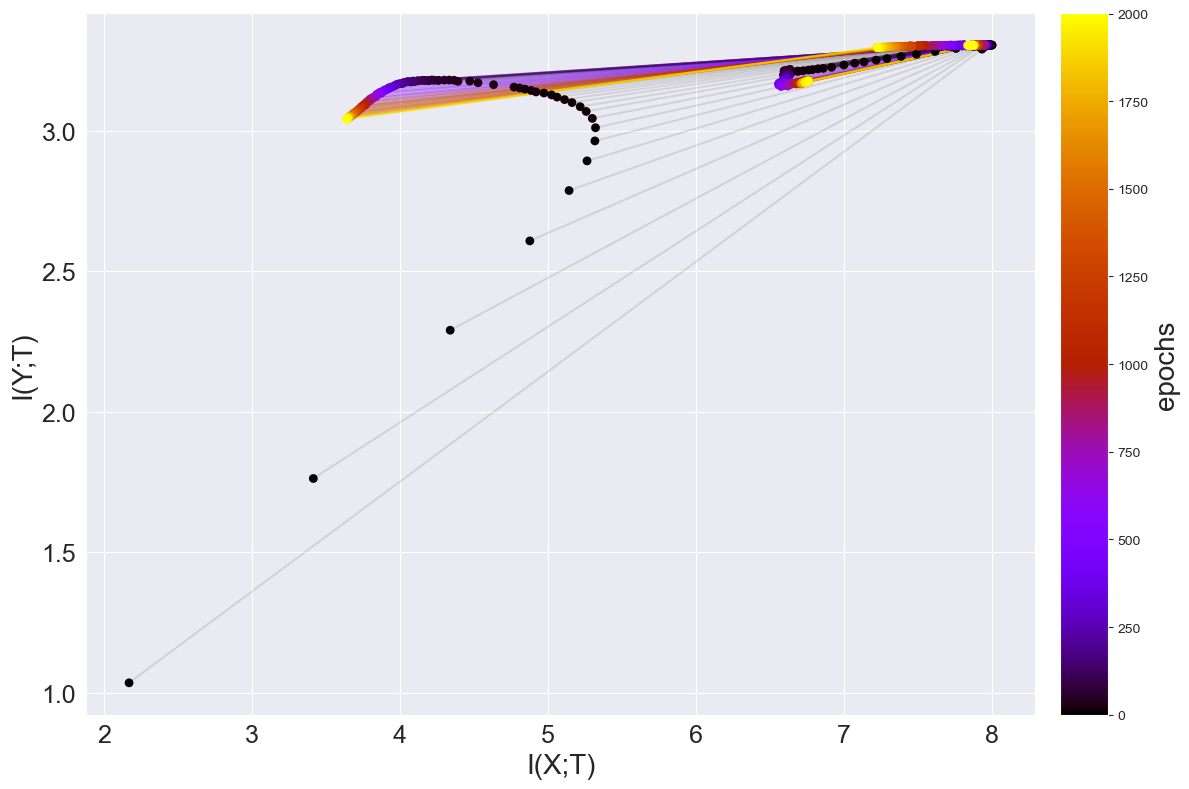

In [27]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

import matplotlib.gridspec as gridspec
sns.set_style('darkgrid')
max_epoch = max( (max(vals.keys()) if len(vals) else 0) for vals in measures.values())
sm = plt.cm.ScalarMappable(cmap='gnuplot', norm=plt.Normalize(vmin=0, vmax=COLORBAR_MAX_EPOCHS))
sm.set_array([])
from mpl_toolkits.axes_grid1 import make_axes_locatable

# fig=plt.figure(figsize=(10,8))
infoplane_measure = "matrix"
fig, ax = plt.subplots(figsize=(12, 8))
for actndx, (activation, vals) in enumerate(measures.items()):
    epochs = sorted(vals.keys())
    if not len(epochs):
        continue
    # plt.subplot(1,2,actndx+1)    
    for epoch in epochs:
        c = sm.to_rgba(epoch)
        xmvals = np.array(vals[epoch]['MI_XM_'+infoplane_measure])[PLOT_LAYERS]
        ymvals = np.array(vals[epoch]['MI_YM_'+infoplane_measure])[PLOT_LAYERS]

        plt.plot(xmvals, ymvals, c=c, alpha=0.1, zorder=1)
        plt.scatter(xmvals, ymvals, s=40, facecolors=[c for _ in PLOT_LAYERS], edgecolor='none', zorder=2)
    
    # plt.ylim([0, 3.5])
    # plt.xlim([0, 14])
    plt.xlabel('I(X;T)', fontsize=20)
    plt.ylabel('I(Y;T)', fontsize=20)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    divider = make_axes_locatable(ax)

    cax = divider.append_axes("right", size="5%", pad=0.25)
    cbar = plt.colorbar(sm, cax=cax)
    # cax.yaxis.set_ticks([])  # Remove ticks
    cbar.set_label('epochs', fontsize=20)
    cax.yaxis.set_ticks_position('right')  # Make ticks appear on the left side
    

    plt.tight_layout()

DO_SAVE =False
if DO_SAVE:
    plt.savefig('plots/' + ('infoplane_'+ARCH+"_"+activation+"_"+infoplane_measure),bbox_inches='tight')
    

NameError: name 'python' is not defined